Import good.
Save MAP good.
Data read good.
16942
1846  vs  677.68


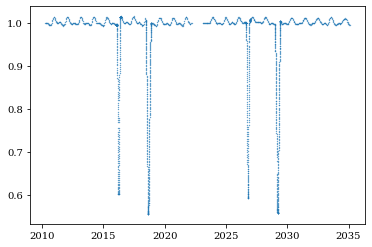

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import starry
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet
import theano.tensor as tt
import arviz as az


plt.rcParams['font.family'] = 'Serif'

starry.config.quiet = True
starry.config.lazy = True

print("Import good.")

#primary limb darkening
u1_m = 0.124
u1_e = 0.1
u2_m = 0.262 
u2_e = 0.1


#primary mass and radius
A_m_m = 5.1
A_m_e = 0.2
A_r_m = 2.4
A_r_e = 0.3

#primary rot period and tpole
A_prot_m =  1.07 #in days
A_omega = 0.225 #dimensionless
A_prot_e = 0.1

A_tpole_m = 17300
A_tpole_e = 800

#secondary luminosity ratio
B_amp_l = 0.6
B_amp_u = 0.8
#secondary mass and radius
B_m_m = 4.4
B_m_e = 0.2
B_r_m = 2.5
B_r_e = 0.3

#secondary tpole
B_tpole_m = 15400
B_tpole_e = 800

#secondary vsini
B_vsini_m = 100
B_vsini_e = 30

#orbital parameters
orb_inc_m = 88.90036698
orb_inc_e = 1.0
orb_period = 10.54980498
orb_ecc = 0.50002396
long_periastron = 327.28588277
long_ascend = 90 #106


G_mks = 6.67e-11
Msun = 1.989e+30
Rsun = 6.95700e8

map_soln = {'A_M_lowerbound__': np.array(1.62944291),
 'A_R_lowerbound__': np.array(0.98037289),
 'A inc_periodic__': np.array([ 2.64709232, -3.60451579]),
 'A_prot_lowerbound__': np.array(0.07237746),
 'u1_lowerbound__': np.array(-2.24535639),
 'u2_lowerbound__': np.array(-1.84569244),
 'B_R_lowerbound__': np.array(0.90174968),
 'period_lowerbound__': np.array(2.35610737),
 'inc orb_interval__': np.array(-7.80442223),
 'ecc_interval__': np.array(-6.03156992),
 'long periastron_interval__': np.array(0.70180696),
 't0_interval__': np.array(0.10218496),
 'A_M': np.array(5.10103218),
 'A_R': np.array(2.66544997),
 'A inc': np.array(1.41243868),
 'A inc deg': np.array(80.92677536),
 'A_prot': np.array(1.07506106),
 'u1': np.array(0.1058898),
 'u2': np.array(0.15791594),
 'B_R': np.array(2.4639104),
 'period': np.array(10.54980498),
 'inc orb': np.array(88.90036698),
 'ecc': np.array(0.50002396),
 'long periastron': np.array(327.28588277),
 't0': np.array(2018.67830961)}
    
with open('MAPSoln.txt', 'w') as MAPfile:
     MAPfile.write(str(map_soln))

print("Save MAP good.")



time = []; flux = []; ferr = []
with open("timedata.txt", 'r') as timedata:
    for t in timedata:
        time.append(float(t))
with open("fluxdata.txt", 'r') as fluxdata:
    for f in fluxdata:
        flux.append(float(f))
with open("ferrdata.txt", 'r') as ferrdata:
    for err in ferrdata:
        ferr.append(float(err))

time = np.array(time); flux = np.array(flux); ferr = np.array(ferr)

print("Data read good.")

MidPrimary1 = map_soln["t0"]; MidPrimary2 = map_soln["t0"] + orb_period
primary1index = [i for i, t in enumerate(time) if (MidPrimary1 - 0.23) <= t <= (MidPrimary1 + 0.23)]
primary2index = [i for i, t in enumerate(time) if (MidPrimary2 - 0.23) <= t <= (MidPrimary2 + 0.23)]

sec_t0 = 0; sec_t0Flux = 1
for i, t in enumerate(time):
    if 2015 <= t <= 2018:
        if flux[i] < sec_t0Flux:
            sec_t0Flux = flux[i]; sec_t0 = t
MidSecondary1 = sec_t0; MidSecondary2 = sec_t0 + orb_period
secondary1index = [i for i, t in enumerate(time) if (MidSecondary1 - 0.2) <= t <= (MidSecondary1 + 0.2)]
secondary2index = [i for i, t in enumerate(time) if (MidSecondary2 - 0.2) <= t <= (MidSecondary2 + 0.2)]

print(len(time))

reduct = 25     # the number of times reduction in the number of data points
running_ind = 0
running_time, running_flux, running_ferr = [], [], []
time_input, flux_input, ferr_input = [], [], []
for i, t in enumerate(time):
    if i not in primary1index + primary2index + secondary1index + secondary2index:
        running_time.append(t)
        running_flux.append(flux[i])
        running_ferr.append(ferr[i])
        if running_ind%reduct == 0:
            running_ind = 0
            time_input.append(np.mean(running_time))
            flux_input.append(np.mean(running_flux))
            ferr_input.append(np.mean(running_ferr))
            running_time, running_flux, running_ferr = [], [], []
        running_ind += 1
    else:
        if running_ind != 0:
            running_ind = 0
            time_input.append(np.mean(running_time))
            flux_input.append(np.mean(running_flux))
            ferr_input.append(np.mean(running_ferr))
            running_time, running_flux, running_ferr = [], [], []
        time_input.append(t)
        flux_input.append(flux[i])
        ferr_input.append(ferr[i])

time_input = np.array(time_input)
flux_input = np.array(flux_input)
ferr_input = np.array(ferr_input)

print(len(time_input), " vs ", len(time) / reduct)
plt.scatter(time_input, flux_input, s=0.1)

# time_input = np.array([t for i, t in enumerate(time) if i%reduct == 0])
# flux_input = np.array([t for i, t in enumerate(flux) if i%reduct == 0])
# ferr_input = np.array([t for i, t in enumerate(ferr) if i%reduct == 0])